# Task B
In general, a basic neural network architecture can be considered that consists of an input  
layer, one or more hidden layers, and an output layer.  

You  are  supposed  to  build  15  distinct  artificial  neural  network  classifiers  by  varying  one  or 
more paramours from the following list: 

- (i). Number of hidden layers – 2 or 3
- (ii) Total number of neurons in the hidden layer is 100 or 150
- (iii) Activation function is from any of the following functions: tanh, sigmoid, ReLu

---

You need to train your network on the MNIST dataset. You can use any optimization algorithm 
like  stochastic  gradient  descent  or  Adam  optimizer.  You  need  to  evaluate  your  network's 
performance on a test set of images from the MNIST dataset. You can calculate the accuracy and 
confusion matrix to measure your network's performance. 
Perform a comparative study of these 15 models and figure out the best classifier. Do you have 
a classifier that  is not statistically significant from the best classifier? Detail the results with all 
explanations.

## Importing the Libraries

In [2]:
# Importing PyTorch
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Importing TorchVision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.0+cpu
torchvision version: 0.15.1+cpu


## Importing the Dataset

In [4]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

5


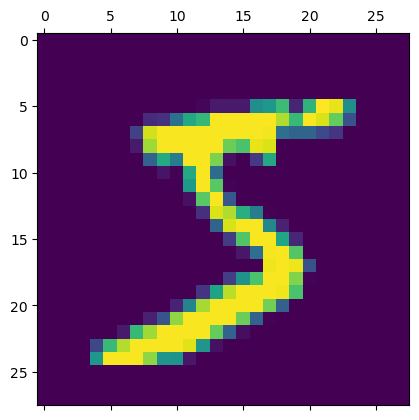

In [5]:
# Check one of the data set
image, label = train_data[0]

# Print the image
plt.matshow(image[0])

# Print the output
print(label)

In [6]:
image.shape

torch.Size([1, 28, 28])

In [7]:
# Let's check the size of datasets
len(train_data.data), len(test_data.data), len(train_data.targets), len(test_data.targets)

(60000, 10000, 60000, 10000)

## Loading the Data

In [8]:
# What this step is practically doing is converting all the data into batches of 32
# And returning the iterables to us

from torch.utils.data import DataLoader

train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=100,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    shuffle=False
)

print(f"Dataloaders: {train_data_loader}, {test_data_loader}")
print(f"Length of train dataloader: {len(train_data_loader)} batches of {100}")
print(f"Length of test dataloader: {len(test_data_loader)}")


Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x000001E3F4471AC0>, <torch.utils.data.dataloader.DataLoader object at 0x000001E3F44713D0>
Length of train dataloader: 600 batches of 100
Length of test dataloader: 10000


## Making the Model

In [9]:
class MNISTModel(nn.Module):
    def __init__(self, input_shape, hidden_layers, hidden_units, activation_func, output_shape, subtract=False):
        # Call the super class's init function
        super().__init__()
        
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
        )
        self.hidden_units = hidden_units
        
        for i in range(hidden_layers):
            if(subtract == True):
                self.layer_stack.append(nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units - 50))
            else:
                self.layer_stack.append(nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units))
            
            if(subtract == True):
                self.hidden_units -= 50
                
            if activation_func == "t":
                self.layer_stack.append(nn.Tanh())
            elif activation_func == "s":
                self.layer_stack.append(nn.Sigmoid())
            elif activation_func == "r":
                self.layer_stack.append(nn.ReLU())
        
        self.layer_stack.append(nn.Linear(in_features=self.hidden_units, out_features=output_shape))
        self.layer_stack.append(nn.LogSoftmax())
    
    def forward(self, x):
        return self.layer_stack(x)

## Writing Loss Functions

In [10]:
mnistModel = MNISTModel(
    input_shape=784,
    hidden_layers=3,
    hidden_units=100,
    output_shape=10,
    activation_func="s"
)
mnistModel.to('cpu')

MNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=100, out_features=10, bias=True)
    (10): LogSoftmax(dim=None)
  )
)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnistModel.parameters(), lr=0.001)

## Training the Model

In [12]:
# ---------Training---------
epochs = 10

# Create the training and testing loop
for epoch in range(epochs):    
        
    for batch, (X, y) in enumerate(train_data_loader):
        # Train the model
        mnistModel.train()
        # Generate Value
        y_pred = mnistModel(X)
        # Generate loss from loss function
        loss = loss_fn(y_pred, y)
        # Optimize :)
        # Apparently this sets all gradients to zero
        optimizer.zero_grad()
        # Back Propagate
        loss.backward()
        optimizer.step()
    
        # if (batch+1) % 2 == 0:
        #         print (f'Epoch [{epoch+1}/{epochs}], Step[{batch+1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')

        

## Testing the Model

### Checking Accuracy

In [14]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    y_pred = []
    y_true = []

    # We loop through all the test data
    for images, labels in test_data_loader:
        # Generate output for one model
        outputs = mnistModel(images)
        # Max returns (value ,index) i.e we need to check which digit has higher probability
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted[0])
        y_true.append(labels[0])

In [16]:
import sklearn.metrics as metrics

print(metrics.confusion_matrix(y_true, y_pred))

[[ 967    0    1    1    1    3    1    1    2    3]
 [   0 1127    3    1    0    1    1    0    2    0]
 [   5    6  987   11    1    0    1   13    8    0]
 [   0    0    1  992    0    3    0    3    6    5]
 [   0    1    3    0  941    3    4    2    6   22]
 [   1    0    0   24    1  841    1    0   15    9]
 [   7    2    3    0   10    7  922    0    7    0]
 [   1   11    6    3    0    0    0  996    2    9]
 [   2    2    2    7    1    2    1    5  948    4]
 [   1    4    0   11    5    2    1    6   11  968]]


In [ ]:
print("Classification report for ANN :\n%s\n"
      % (metrics.classification_report(y_true, y_pred, digits=6)))

## Iterating through all models


In [ ]:
def iterate_through_12():
    hidden_sizes = [2, 3]
    neurons_in_hidden_layers = [100, 150]
    activation_functions = ["t", "s", "r"]
    epochs = 100
    model_no = 0

    for hs in hidden_sizes:
        for nihl in neurons_in_hidden_layers:
            for af in activation_functions:
                model_no += 1
                
                mnistModel = MNISTModel(
                    input_shape=784,
                    hidden_layers=hs,
                    hidden_units=nihl,
                    output_shape=10,
                    activation_func=af
                )
                
                print(f"Model #{model_no}")
                
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(mnistModel.parameters(), lr=0.001)

                # ---------Training---------
                # Create the training and testing loop
                for epoch in range(epochs):    
                        
                    for batch, (X, y) in enumerate(train_data_loader):
                        # Train the model
                        mnistModel.train()
                        # Generate Value
                        y_pred = mnistModel(X)
                        # Generate loss from loss function
                        loss = loss_fn(y_pred, y)
                        # Optimize :)
                        # Apparently this sets all gradients to zero
                        optimizer.zero_grad()
                        # Back Propagate
                        loss.backward()
                        optimizer.step()
                        
                        # Debugging Purposes only, Do not use in the loop
                        # if (batch+1) % 100 == 0:
                        #         print (f'Epoch [{epoch+1}/{epochs}], Step[{batch+1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')

                with torch.no_grad():                
                    y_pred = []
                    y_true = []

                    # We loop through all the test data
                    for images, labels in test_data_loader:
                        # Generate output for one model
                        outputs = mnistModel(images)
                        # Max returns (value ,index) i.e we need to check which digit has higher probability
                        _, predicted = torch.max(outputs.data, 1)
                        y_pred.append(predicted[0])
                        y_true.append(labels[0])

                print(metrics.confusion_matrix(y_true, y_pred))
                print(f"Classification report for Hidden Layers: {hs}, Neurons in Each Hidden Layer: {nihl}, Activation Function: {af} :\n%s\n"
                    % (metrics.classification_report(y_true, y_pred, digits=6)))

### Model #1-#12

In [ ]:
iterate_through_12()

### Model #13

In [16]:
mnistModel = MNISTModel(
    input_shape=784,
    hidden_layers=2,
    hidden_units=150,
    output_shape=10,
    activation_func="t",
    subtract=True
)

print(mnistModel)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnistModel.parameters(), lr=0.001)

# ---------Training---------
# Create the training and testing loop
for epoch in range(1):
    for batch, (X, y) in enumerate(train_data_loader):
        # Train the model
        mnistModel.train()
        # Generate Value
        y_pred = mnistModel(X)
        # Generate loss from loss function
        loss = loss_fn(y_pred, y)
        # Optimize :)
        # Apparently this sets all gradients to zero
        optimizer.zero_grad()
        # Back Propagate
        loss.backward()
        optimizer.step()

        # Debugging Purposes only, Do not use in the loop
        # if (batch+1) % 100 == 0:
        #         print (f'Epoch [{epoch+1}/{epochs}], Step[{batch+1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')

with torch.no_grad():
    y_pred = []
    y_true = []

    # We loop through all the test data
    for images, labels in test_data_loader:
        # Generate output for one model
        outputs = mnistModel(images)
        # Max returns (value ,index) i.e we need to check which digit has higher probability
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted[0])
        y_true.append(labels[0])

print(metrics.confusion_matrix(y_true, y_pred))
print(f"Classification report for Hidden Layers: 2, Neurons in Each Hidden Layer: 150, Activation Function: t :\n%s\n" % (metrics.classification_report(y_true, y_pred, digits=6)))

MNISTModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=150, bias=True)
    (2): ReLU()
    (3): Linear(in_features=150, out_features=100, bias=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=50, bias=True)
    (6): Tanh()
    (7): Linear(in_features=50, out_features=10, bias=True)
    (8): LogSoftmax(dim=None)
  )
)
Classification report for Hidden Layers: 2, Neurons in Each Hidden Layer: 150, Activation Function: t :
              precision    recall  f1-score   support

           0   0.967033  0.987755  0.977284       980
           1   0.982456  0.986784  0.984615      1135
           2   0.933583  0.967054  0.950024      1032
           3   0.947368  0.944554  0.945959      1010
           4   0.966632  0.943992  0.955178       982
           5   0.967630  0.938341  0.952760       892
           6   0.978678  0.958246  0.968354       958
           7   0.952565  0.957198  0.954876      10

### Model #14

In [ ]:
mnistModel = MNISTModel(
    input_shape=784,
    hidden_layers=2,
    hidden_units=150,
    output_shape=10,
    activation_func="s"
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnistModel.parameters(), lr=0.001)

# ---------Training---------
# Create the training and testing loop
for epoch in range(100):
    for batch, (X, y) in enumerate(train_data_loader):
        # Train the model
        mnistModel.train()
        # Generate Value
        y_pred = mnistModel(X)
        # Generate loss from loss function
        loss = loss_fn(y_pred, y)
        # Optimize :)
        # Apparently this sets all gradients to zero
        optimizer.zero_grad()
        # Back Propagate
        loss.backward()
        optimizer.step()

        # Debugging Purposes only, Do not use in the loop
        # if (batch+1) % 100 == 0:
        #         print (f'Epoch [{epoch+1}/{epochs}], Step[{batch+1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')

with torch.no_grad():
    y_pred = []
    y_true = []

    # We loop through all the test data
    for images, labels in test_data_loader:
        # Generate output for one model
        outputs = mnistModel(images)
        # Max returns (value ,index) i.e we need to check which digit has higher probability
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted[0])
        y_true.append(labels[0])

print(metrics.confusion_matrix(y_true, y_pred))
print(f"Classification report for Hidden Layers: 2, Neurons in Each Hidden Layer: 150, Activation Function: t :\n%s\n" % (metrics.classification_report(y_true, y_pred, digits=6)))

### Model #15

In [ ]:
mnistModel = MNISTModel(
    input_shape=784,
    hidden_layers=2,
    hidden_units=150,
    output_shape=10,
    activation_func="r"
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnistModel.parameters(), lr=0.001)

# ---------Training---------
# Create the training and testing loop
for epoch in range(100):
    for batch, (X, y) in enumerate(train_data_loader):
        # Train the model
        mnistModel.train()
        # Generate Value
        y_pred = mnistModel(X)
        # Generate loss from loss function
        loss = loss_fn(y_pred, y)
        # Optimize :)
        # Apparently this sets all gradients to zero
        optimizer.zero_grad()
        # Back Propagate
        loss.backward()
        optimizer.step()

        # Debugging Purposes only, Do not use in the loop
        # if (batch+1) % 100 == 0:
        #         print (f'Epoch [{epoch+1}/{epochs}], Step[{batch+1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')

with torch.no_grad():
    y_pred = []
    y_true = []

    # We loop through all the test data
    for images, labels in test_data_loader:
        # Generate output for one model
        outputs = mnistModel(images)
        # Max returns (value ,index) i.e we need to check which digit has higher probability
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted[0])
        y_true.append(labels[0])

print(metrics.confusion_matrix(y_true, y_pred))
print(f"Classification report for Hidden Layers: 2, Neurons in Each Hidden Layer: 150, Activation Function: t :\n%s\n" % (metrics.classification_report(y_true, y_pred, digits=6)))